In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import math
import numpy as np
import matplotlib.pyplot as plt
from math import log, e
import torch.optim as optim
import pickle
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import normalize

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
plt.rcParams.update({'font.size': 20, 'figure.figsize': (8,8), 'axes.axisbelow':True})

torch.manual_seed(24)
np.random.seed(24)

In [92]:
#utils

def entropy(dispatch, base=None):
    """ Computes entropy of label distribution. """
    n_expert = torch.sum(dispatch, axis=0)
    n_total = torch.sum(dispatch)
    
    prob = dispatch / n_expert
    ent = - torch.nansum(prob*torch.log(prob), axis=0)
    ent = torch.sum((n_expert / n_total) * ent)
    
    return ent

def plot_expert_acc(expert_acc,uplim=0.5):
    fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(15,15))
    i = 0
    colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
    
    for row in ax:
        for col in row:
            col.set_ylim([0,torch.max(expert_acc)+uplim])
            if i == EXPERT_NUM:
                break
            for j in range(CLUSTER_NUM):
                col.plot(expert_acc[i][j], label='cluser '+str(j+1), color=colors[j])
            if i == 0:
                col.legend(loc='upper left')
            col.title.set_text('Expert %d'%(i+1))
            i+=1

    plt.plot()
    

def plot_router_acc(expert_acc,uplim=0.5):
    fig, ax = plt.subplots(nrows=4, ncols=2,figsize=(15,15))
    i = 0
    expert_acc = torch.tensor(expert_acc).squeeze(-1)
    colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
    
    for row in ax:
        for col in row:
            col.set_ylim([0,torch.max(expert_acc)+uplim])
            if i == EXPERT_NUM:
                break
            for j in range(CLUSTER_NUM):
                col.plot(expert_acc[j,:,i], label='cluser '+str(j+1), color=colors[j])
            if i == 0:
                col.legend(loc='upper left')
            col.title.set_text('Theta %d'%(i+1))
            i+=1

    plt.plot()


class ConvNet(nn.Module):
    def __init__(self, input_dim, out_channel, patch_num, small=True, nonlinear=True):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv1d(1, out_channel*2, int(input_dim/patch_num), int(input_dim/patch_num))        
        # small initialization
        if small:
            self.conv1.weight = torch.nn.Parameter(self.conv1.weight*0.001) 
            self.conv1.bias = torch.nn.Parameter(self.conv1.bias*0.001) 
        self.out_channel = out_channel
        self.nonlinear = nonlinear

    def forward(self, x):
        x = self.conv1(x)
        if self.nonlinear:
            x = x**3
        x = torch.sum(x,2)
        output = torch.stack([torch.sum(x[:,:self.out_channel],1), torch.sum(x[:,self.out_channel:],1)]).transpose(1,0)
        return output
    

# top 1 hard routing
def top1(t):
    values, index = t.topk(k=1, dim=-1)
    values, index = map(lambda x: x.squeeze(dim=-1), (values, index))
    return values, index


def cumsum_exclusive(t, dim=-1):
    num_dims = len(t.shape)
    num_pad_dims = - dim - 1
    pre_padding = (0, 0) * num_pad_dims
    pre_slice   = (slice(None),) * num_pad_dims
    padded_t = F.pad(t, (*pre_padding, 1, 0)).cumsum(dim=dim)
    return padded_t[(..., slice(None, -1), *pre_slice)]


def safe_one_hot(indexes, max_length):
    max_index = indexes.max() + 1
    return F.one_hot(indexes, max(max_index + 1, max_length))[..., :max_length]


def gumbel_noise(n,k):
    unif = torch.distributions.Uniform(0,1).sample((n,k))
    g = -torch.log(-torch.log(unif))
    return g

class Router(nn.Module):
    def __init__(self, input_dim, out_dim, patch_num, strategy='top1',noise=None, noise_type='gumbel'):
        super(Router, self).__init__()
        self.conv1 = nn.Conv1d(1, out_dim, int(input_dim/patch_num), int(input_dim/patch_num),bias=False)
        self.out_dim = out_dim
        self.strategy = strategy
        if self.strategy == 'top1':
            if noise is None:
                if noise_type == 'normal':
                    self.noise = torch.rand(DATA_NUM,out_dim).cuda()
                elif noise_type == "gumbel":
                    self.noise = gumbel_noise(DATA_NUM,out_dim).cuda()

            else:
                self.noise = noise
        # zero initialization
        self.reset_parameters()
        self.sm = nn.Softmax()
    
    def reset_parameters(self):
        self.conv1.weight = torch.nn.Parameter(self.conv1.weight * 0)
            
    def forward(self, x):      
        x = self.conv1(x)
        x = torch.sum(x,2)
        if self.strategy == 'top1':
            output = x + self.noise
        else:
            output = x
        return output



class MoE(nn.Module):
    def __init__(self, input_dim, out_channel, patch_num, expert_num, strategy='top1', nonlinear=True, noise=None, noise_type='normal'):
        super(MoE, self).__init__()
        self.router = Router(input_dim, expert_num, patch_num, strategy=strategy, noise=noise, noise_type = noise_type)
        self.models = nn.ModuleList()
        for i in range(expert_num):
            self.models.append(ConvNet(input_dim, out_channel, patch_num, nonlinear=nonlinear))
        self.strategy = strategy
        self.expert_num = expert_num
        # self.learnable_scalar = nn.Parameter(torch.Tensor(1))
        # nn.init.constant_(self.learnable_scalar, 1)

    def forward(self, x):
        select = self.router(x)
        # print("====> select",select.size())
        # top 1 or choose 1 according to probability
        if self.strategy == 'top1':
            gate, index = top1(select)
            # print("======> gate:",gate)
            # print("====> index",index.size())
        else:
            gate, index = choose1(select)
        
        mask = F.one_hot(index, self.expert_num).float()
        # print("====> mask",index.size())
        density = mask.mean(dim=-2)
        density_proxy = select.mean(dim=-2)
        loss = (density_proxy * density).mean() * float(self.expert_num ** 2)

        mask_count = mask.sum(dim=-2, keepdim=True)
        mask_flat = mask.sum(dim=-1)

        combine_tensor =  (gate[..., None, None] * mask_flat[..., None, None]
                          * F.one_hot(index, self.expert_num)[..., None])
        # print("combine_tensor:",combine_tensor[0:10,:,:])
                          
        dispatch_tensor = combine_tensor.bool().to(combine_tensor) # denote expert assignment -- a tensor with 0/1 entries
        # print("dispatch_tensor:",dispatch_tensor)
        select0 = dispatch_tensor.squeeze(-1)
        
        expert_inputs = torch.einsum('bnd,ben->ebd', x, dispatch_tensor).unsqueeze(2)
        
        output = []
        for i in range(self.expert_num):
            output.append(self.models[i](expert_inputs[i]))
        
        output = torch.stack(output)
        output = torch.einsum('ijk,jil->il', combine_tensor, output) # combine gating weights with experts output
        output = F.softmax(output,dim=1)
        # print('learnable scalar:', self.learnable_scalar.item())
        return output, select0, loss, gate, index

In [93]:
def train(model, criterion, data, labels, optimizers, epochs, plot=False, load_balancing=False, verbose=True):
    
    expert_acc_train = [[[] for x in range(CLUSTER_NUM)] for x in range(EXPERT_NUM)]
    expert_inner_train = [[[] for x in range(CLUSTER_NUM)] for x in range(EXPERT_NUM)]
    
    router_acc_train = [[] for x in range(CLUSTER_NUM)]
    router_inner_train = [[] for x in range(CLUSTER_NUM)]

    entropy_record = []
    gating_output = []
    index_ = []
    min_loss = 100
    router_grads = []
    loss_list = []
    for epoch in range(epochs):  
        
        for optimizer in optimizers:
            optimizer.zero_grad()
        outputs, select0, load_balancing_loss, gate, index = model(data)
        gating_output.append(gate.detach().cpu())
        index_.append(index.detach().cpu())
        
        e = entropy(torch.stack([select0[train_cluster_idx[0]].squeeze(-1).sum(dim=0),
                                 select0[train_cluster_idx[1]].squeeze(-1).sum(dim=0),
                                 select0[train_cluster_idx[2]].squeeze(-1).sum(dim=0),
                                 select0[train_cluster_idx[3]].squeeze(-1).sum(dim=0)]))
        entropy_record.append(e)
        
        if load_balancing:
            loss = criterion(outputs, labels) + 0.0001 * load_balancing_loss
        else:
            loss = criterion(outputs, labels)


        if loss.item() <= min_loss:
            min_loss = loss.item()
        elif loss > min_loss+0.02 or loss <= 0.314:
            break
        loss.backward() 

        loss_list.append(loss.item())     
        for optimizer in optimizers:
            optimizer.step()

        router_grads.append(model.router.conv1.weight.grad)
        # print('learnable param grad:',model.learnable_scalar.grad.detach())
        
        if epoch%50 == 0:
            if verbose:
                print('Epoch %d --- loss: %.3f' % (epoch + 1, loss.item()))
            if plot:
                acc_list,inner_list,router_flist,router_clist = test_each_expert(model, criterion, training_data, training_labels, datatype='training')
                for each_cluster in range(CLUSTER_NUM):

                    router_acc_train[each_cluster].append(router_flist[each_cluster])
                    router_inner_train[each_cluster].append(router_clist[each_cluster])

                    for each_expert in range(EXPERT_NUM):
                        expert_acc_train[each_expert][each_cluster].append(acc_list[each_expert][each_cluster])
                        expert_inner_train[each_expert][each_cluster].append(inner_list[each_expert][each_cluster])
            
    print('Finished Training')
    return expert_acc_train,expert_inner_train,router_acc_train,router_inner_train, select0, entropy_record, router_grads, gating_output, index_, loss_list


def test_single(model, criterion, data, labels):
    correct = 0
    
    with torch.no_grad():
        outputs = model(data) # ,_
        predicted = torch.max(outputs.data, 1).indices
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the %d test images: %.4f %%' % (data.shape[0],
        100 * correct / data.shape[0]))
    
    return 100 * correct / data.shape[0]
    

def test(model, criterion, data, labels, verbose=True):
    correct = 0
    
    with torch.no_grad():
        outputs,_,_,_,_ = model(data) # ,_
        predicted = torch.max(outputs.data, 1).indices
        correct += (predicted == labels).sum().item()

    if verbose:
        print('Accuracy of the network on the %d test images: %.4f %%' % (data.shape[0],
            100 * correct / data.shape[0]))
    
    return 100 * correct / data.shape[0]
    
    
def test_expert(model, criterion, data, labels, cluster=0, datatype='training', verbose=False):
    if datatype=='training':
        cluster_idx = train_cluster_idx
    else:
        cluster_idx = test_cluster_idx
        
    data = data[cluster_idx[cluster],:,:]
    labels = labels[cluster_idx[cluster]]
    expert_acc = []
    with torch.no_grad():
        for i in range(model.expert_num):
            correct = 0
            outputs = F.softmax(model.models[i](data),dim=1)
            predicted = torch.max(outputs.data, 1).indices
            correct += (predicted == labels).sum().item()
            acc = 100 * correct / data.shape[0]
            expert_acc.append(acc)
            if verbose:
                print('Accuracy of the %d expert on cluster %d with %d examples: %.4f %%' % (i, cluster, data.shape[0],
                                                                                             acc))
    return expert_acc
        
    
def test_each_expert(model, criterion, data, labels, datatype='training', verbose=False):
    expert_feature = [[] for x in range(EXPERT_NUM)]
    expert_center = [[] for x in range(EXPERT_NUM)]
    router_feature, router_center = test_router_inner(model)

    for i in range(CLUSTER_NUM):
        feat, cent = test_expert_inner(model, cluster=i)
        
        for each in range(EXPERT_NUM):
            expert_feature[each].append(feat[each].cpu())
            expert_center[each].append(cent[each].cpu())
            
    return expert_feature, expert_center, router_feature, router_center


def test_expert_inner(model, cluster=0):
    expert_fea = []
    expert_cen = []
    with torch.no_grad():
        for i in range(model.expert_num):
            feature_inner = torch.max(torch.abs(torch.matmul(model.models[i].conv1.weight.squeeze(1), 
                                         features[[cluster]].float().transpose(1,0))))
            center_inner = torch.max(torch.abs(torch.matmul(model.models[i].conv1.weight.squeeze(1), 
                                         centers[[cluster]].float().transpose(1,0))))
            expert_fea.append(feature_inner)
            expert_cen.append(center_inner)
    return expert_fea, expert_cen


def test_router_inner(model):
    router_feature = []
    router_center = []
    with torch.no_grad():
        for cluster in range(CLUSTER_NUM):
            ### torch.max
            feature_inner = torch.abs(torch.matmul(model.router.conv1.weight.squeeze(1), 
                                         features[[cluster]].float().transpose(1,0)))
            center_inner = torch.abs(torch.matmul(model.router.conv1.weight.squeeze(1), 
                                         centers[[cluster]].float().transpose(1,0)))
            router_feature.append(feature_inner.cpu().tolist())
            router_center.append(center_inner.cpu().tolist())
    return router_feature, router_center

In [94]:
from torch.optim.optimizer import Optimizer, required
from torch.optim import _functional

class NormalizedGD(Optimizer):
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(NormalizedGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(NormalizedGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']
            lr = group['lr']

            for p in group['params']:
                if p.grad is not None:
                    # Normalizing 
                    if p.grad.norm() != 0:
                        p.grad /= p.grad.norm()
                        
                    params_with_grad.append(p)
                    d_p_list.append(p.grad)

                    state = self.state[p]
                    if 'momentum_buffer' not in state:
                        momentum_buffer_list.append(None)
                    else:
                        momentum_buffer_list.append(state['momentum_buffer'])

            _functional.sgd(params_with_grad,
                  d_p_list,
                  momentum_buffer_list,
                  weight_decay=weight_decay,
                  momentum=momentum,
                  lr=lr,
                  dampening=dampening,
                  nesterov=nesterov,
                  maximize=False)

            # update momentum_buffers in state
            for p, momentum_buffer in zip(params_with_grad, momentum_buffer_list):
                state = self.state[p]
                state['momentum_buffer'] = momentum_buffer

        return loss

In [95]:
DATA_NUM = 1600
CLUSTER_NUM = 4
EXPERT_NUM = 4
PATCH_NUM = 4
PATCH_LEN = 50

def make_orthogonal(x):
    for i in range(CLUSTER_NUM):
        x /= np.linalg.norm(x)
        x -= x.dot(features[i]) * features[i]
        x /= np.linalg.norm(x)
        x -= x.dot(centers[i]) * centers[i]
    
    x /= np.linalg.norm(x)
    return x

features = torch.zeros(CLUSTER_NUM, PATCH_LEN)
x = np.random.randn(50) 
x /= np.linalg.norm(x)
current_x = []
for i in range(CLUSTER_NUM):
    features[i] = torch.tensor(x)
    current_x.append(x)
    x = np.random.randn(PATCH_LEN) 
    x /= np.linalg.norm(x)
    for x_prev in current_x:
        x -= x.dot(x_prev) * x_prev
    x /= np.linalg.norm(x)

centers = torch.zeros(CLUSTER_NUM, PATCH_LEN)
for i in range(CLUSTER_NUM):
    centers[i] = torch.tensor(x)
    if i!=3:
        current_x.append(x)
        x = np.random.randn(PATCH_LEN) 
        x /= np.linalg.norm(x)
        for x_prev in current_x:
            x -= x.dot(x_prev) * x_prev
        x /= np.linalg.norm(x)


data = []
labels = []
train_cluster_idx = [[] for x in range(CLUSTER_NUM)]
test_cluster_idx = [[] for x in range(CLUSTER_NUM)]

for i in range(DATA_NUM*2):
    y = np.random.choice([-1,1], 1)[0] 
    k = np.random.choice(list(range(0,CLUSTER_NUM)))
    
    if i < DATA_NUM:
        train_cluster_idx[k].append(i)
    else:
        test_cluster_idx[k].append(i-DATA_NUM)

    # Noise patch
    xi = torch.tensor(np.random.normal(0, 1, size=(PATCH_LEN)))
    xi = make_orthogonal(xi.float())
    
    # Feature noise patch
    pos_or_neg = np.random.choice([-1,1], 1)[0]
    k_noise = np.random.choice(list(set(range(0,CLUSTER_NUM))-set([int(k)])))
    alpha, beta = 1, np.random.uniform(1,2) #np.random.uniform(0.5,1)
    theta = np.random.uniform(1.2,2)

    x = torch.stack([features[k]*y*alpha, centers[k]*theta, xi*3, 
                     pos_or_neg*features[k_noise]*beta])
    
    # random permutation
#     idx = torch.randperm(len(x))
    x = x.flatten()

    data.append(x)
    labels.append(y)

data = torch.stack(data)
print(data.shape)

labels = torch.tensor(labels)
labels[labels==-1] = 0
print(labels.shape)

training_data = data[:DATA_NUM,:].unsqueeze(1).float().cuda()
test_data = data[DATA_NUM::].unsqueeze(1).float().cuda()
print(training_data.shape, test_data.shape)

training_labels = labels[:DATA_NUM].cuda()
test_labels = labels[DATA_NUM:].cuda()
print(training_labels.shape, test_labels.shape)

training_labels = training_labels.long()
test_labels = test_labels.long()
training_data *= 10
test_data *= 10
# Below does not affect training, just for plotting
centers *= 10
features *= 10


torch.Size([3200, 200])
torch.Size([3200])
torch.Size([1600, 1, 200]) torch.Size([1600, 1, 200])
torch.Size([1600]) torch.Size([1600])


In [6]:
pca = TSNE(n_components=2)
visual_data = pca.fit_transform(data[:DATA_NUM,:].float().cpu()/10)
visual_data = visual_data/np.max(np.abs(visual_data))

In [7]:
for i in range(DATA_NUM):
    idx = torch.randperm(PATCH_NUM)
    stack_data = torch.stack([training_data[i,0,:][j*PATCH_LEN:(j+1)*PATCH_LEN] for j in range(PATCH_NUM)])
    stack_data = stack_data[idx].flatten()
    training_data[i,0,:] = stack_data

    idx = torch.randperm(PATCH_NUM)
    stack_data = torch.stack([test_data[i,0,:][j*PATCH_LEN:(j+1)*PATCH_LEN] for j in range(PATCH_NUM)])
    stack_data = stack_data[idx].flatten()
    test_data[i,0,:] = stack_data

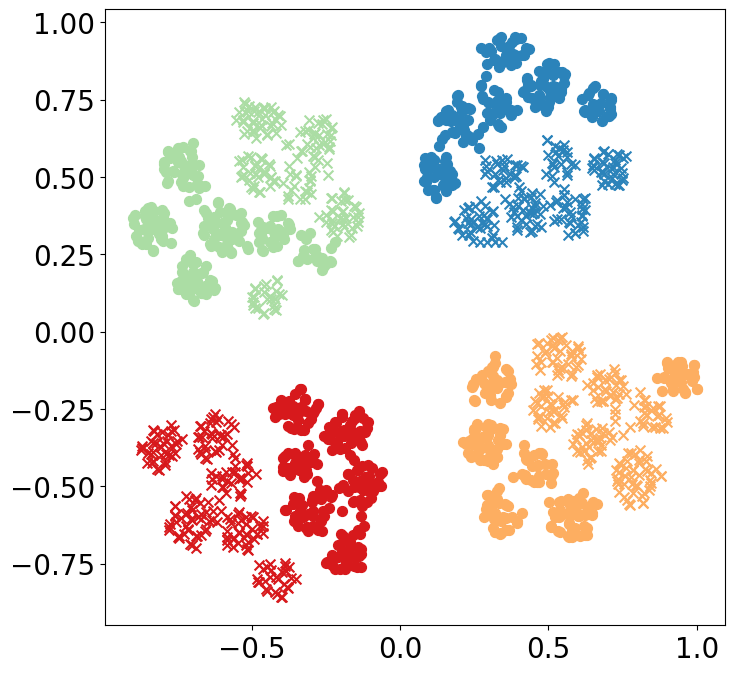

In [8]:
plt.scatter(visual_data[np.array(train_cluster_idx[0])[training_labels.cpu()[train_cluster_idx[0]] == 0],0],visual_data[np.array(train_cluster_idx[0])[training_labels.cpu()[train_cluster_idx[0]] == 0],1], s=50, marker='x',color='#d7191c')
plt.scatter(visual_data[np.array(train_cluster_idx[0])[training_labels.cpu()[train_cluster_idx[0]] == 1],0],visual_data[np.array(train_cluster_idx[0])[training_labels.cpu()[train_cluster_idx[0]] == 1],1], s=50, marker='o',color='#d7191c')

plt.scatter(visual_data[np.array(train_cluster_idx[1])[training_labels.cpu()[train_cluster_idx[1]] == 0],0],visual_data[np.array(train_cluster_idx[1])[training_labels.cpu()[train_cluster_idx[1]] == 0],1], s=50, marker='x',color='#fdae61')
plt.scatter(visual_data[np.array(train_cluster_idx[1])[training_labels.cpu()[train_cluster_idx[1]] == 1],0],visual_data[np.array(train_cluster_idx[1])[training_labels.cpu()[train_cluster_idx[1]] == 1],1], s=50, marker='o',color='#fdae61')

plt.scatter(visual_data[np.array(train_cluster_idx[2])[training_labels.cpu()[train_cluster_idx[2]] == 0],0],visual_data[np.array(train_cluster_idx[2])[training_labels.cpu()[train_cluster_idx[2]] == 0],1], s=50, marker='x',color='#abdda4')
plt.scatter(visual_data[np.array(train_cluster_idx[2])[training_labels.cpu()[train_cluster_idx[2]] == 1],0],visual_data[np.array(train_cluster_idx[2])[training_labels.cpu()[train_cluster_idx[2]] == 1],1], s=50, marker='o',color='#abdda4')

plt.scatter(visual_data[np.array(train_cluster_idx[3])[training_labels.cpu()[train_cluster_idx[3]] == 0],0],visual_data[np.array(train_cluster_idx[3])[training_labels.cpu()[train_cluster_idx[3]] == 0],1], s=50, marker='x',color='#2b83ba')
plt.scatter(visual_data[np.array(train_cluster_idx[3])[training_labels.cpu()[train_cluster_idx[3]] == 1],0],visual_data[np.array(train_cluster_idx[3])[training_labels.cpu()[train_cluster_idx[3]] == 1],1], s=50, marker='o',color='#2b83ba')

In [9]:
noise = torch.rand(DATA_NUM,EXPERT_NUM).cuda()
nonlinear_mixture = MoE(200, 10, PATCH_NUM, EXPERT_NUM, strategy='top1', nonlinear=True, noise=None, noise_type='normal').cuda() #input_dim, out_channel (m), cluter_num, patch_num

pred, s, _, _ = nonlinear_mixture(training_data)
print(s.squeeze(-1).sum(dim=0))

tensor([382., 410., 403., 405.], device='cuda:0')


In [10]:
expert_1 = (s[:,0] == 1).cpu()
expert_2 = (s[:,1] == 1).cpu()
expert_3 = (s[:,2] == 1).cpu()
expert_4 = (s[:,3] == 1).cpu()

expert_1_idx = torch.arange(DATA_NUM).long()[expert_1]
expert_2_idx = torch.arange(DATA_NUM).long()[expert_2]
expert_3_idx = torch.arange(DATA_NUM).long()[expert_3]
expert_4_idx = torch.arange(DATA_NUM).long()[expert_4]

In [11]:
resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(visual_data[:,0]), np.max(visual_data[:,0])
X2d_ymin, X2d_ymax = np.min(visual_data[:,1]), np.max(visual_data[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(visual_data, torch.max(pred.data, 1).indices.cpu().numpy()) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

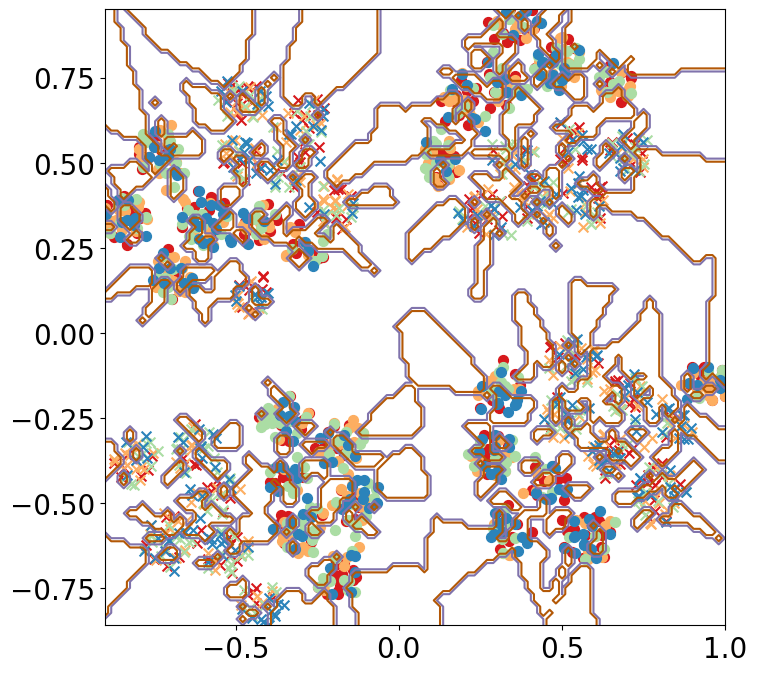

In [12]:
plt.scatter(visual_data[np.array(expert_1_idx)[training_labels.cpu()[expert_1] == 0],0],visual_data[np.array(expert_1_idx)[training_labels.cpu()[expert_1] == 0],1], s=50, marker='x',color='#d7191c')
plt.scatter(visual_data[np.array(expert_1_idx)[training_labels.cpu()[expert_1] == 1],0],visual_data[np.array(expert_1_idx)[training_labels.cpu()[expert_1] == 1],1], s=50, marker='o',color='#d7191c')

plt.scatter(visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 0],0],visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 0],1], s=50, marker='x',color='#fdae61')
plt.scatter(visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 1],0],visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 1],1], s=50, marker='o',color='#fdae61')

plt.scatter(visual_data[np.array(expert_3_idx)[training_labels.cpu()[expert_3] == 0],0],visual_data[np.array(expert_3_idx)[training_labels.cpu()[expert_3] == 0],1], s=50, marker='x',color='#abdda4')
plt.scatter(visual_data[np.array(expert_3_idx)[training_labels.cpu()[expert_3] == 1],0],visual_data[np.array(expert_3_idx)[training_labels.cpu()[expert_3] == 1],1], s=50, marker='o',color='#abdda4')

plt.scatter(visual_data[np.array(expert_4_idx)[training_labels.cpu()[expert_4] == 0],0],visual_data[np.array(expert_4_idx)[training_labels.cpu()[expert_4] == 0],1], s=50, marker='x',color='#2b83ba')
plt.scatter(visual_data[np.array(expert_4_idx)[training_labels.cpu()[expert_4] == 1],0],visual_data[np.array(expert_4_idx)[training_labels.cpu()[expert_4] == 1],1], s=50, marker='o',color='#2b83ba')

plt.contour(xx, yy, voronoiBackground, levels=1, colors=['#8073ac','#b35806'])

plt.savefig('initial.pdf')

In [53]:
# for name, param in nonlinear_mixture.named_parameters():
#     print(f"Parameter name: {name}, Size: {param.size()}")

## our MoE model output $\mathbb{1}_{\{\text{argmax}(G(x))=i\}} E_i(x) \cdot G(x)_i$

In [96]:
# Set seeds for Python, NumPy, and PyTorch
seed_value = 7

# Python
import random
random.seed(seed_value)

# NumPy
np.random.seed(seed_value)

# PyTorch
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

num_epochs = 801
noise = torch.rand(DATA_NUM,EXPERT_NUM).cuda()
nonlinear_mixture = MoE(200, 10, PATCH_NUM, EXPERT_NUM, strategy='top1', nonlinear=True, noise=None, noise_type='normal').cuda() #input_dim, out_channel (m), cluter_num, patch_num

criterion = torch.nn.CrossEntropyLoss()
optimizer = NormalizedGD(nonlinear_mixture.models.parameters(), lr=0.001)
optimizer2 = torch.optim.SGD(nonlinear_mixture.router.parameters(), lr=0.1) #top1 lr 0.1


_, _, _, _, select, _, router_grads, gating_outputs, index_, loss_ = train(nonlinear_mixture, criterion, training_data, training_labels, 
                                                           [optimizer,optimizer2], num_epochs, plot=False, load_balancing=False)
print(select.squeeze(-1).sum(dim=0))

test(nonlinear_mixture, criterion, training_data, training_labels)
test(nonlinear_mixture, criterion, test_data, test_labels)

print(select[train_cluster_idx[0]].squeeze(-1).sum(dim=0).to(torch.long))
print(select[train_cluster_idx[1]].squeeze(-1).sum(dim=0).to(torch.long))
print(select[train_cluster_idx[2]].squeeze(-1).sum(dim=0).to(torch.long))
print(select[train_cluster_idx[3]].squeeze(-1).sum(dim=0).to(torch.long))

Epoch 1 --- loss: 0.693
Epoch 51 --- loss: 0.657
Epoch 101 --- loss: 0.450
Epoch 151 --- loss: 0.389
Epoch 201 --- loss: 0.361
Epoch 251 --- loss: 0.343
Epoch 301 --- loss: 0.348
Epoch 351 --- loss: 0.353
Epoch 401 --- loss: 0.354
Epoch 451 --- loss: 0.352
Epoch 501 --- loss: 0.351
Epoch 551 --- loss: 0.350
Epoch 601 --- loss: 0.350
Epoch 651 --- loss: 0.350
Epoch 701 --- loss: 0.350
Epoch 751 --- loss: 0.350
Epoch 801 --- loss: 0.350
Finished Training
tensor([195., 586., 304., 515.], device='cuda:0')
Accuracy of the network on the 1600 test images: 96.3750 %
Accuracy of the network on the 1600 test images: 96.3750 %
tensor([  0, 309,   0, 108], device='cuda:0')
tensor([  0,   1, 291, 122], device='cuda:0')
tensor([159,  84,   0, 151], device='cuda:0')
tensor([ 36, 192,  13, 134], device='cuda:0')


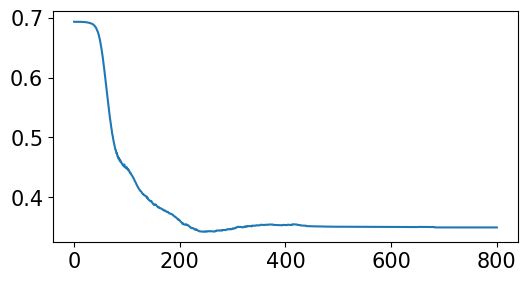

In [99]:
plt.rcParams.update({'font.size': 15, 'figure.figsize': (6,3), 'axes.axisbelow':True})
plt.plot(np.arange(len(loss_)), loss_)

## Here we visualize $\mathbb{1}_{\{\text{argmax}(G(x))=i\}}\cdot G(x)_i$

Text(56.722222222222214, 0.5, '#epochs')

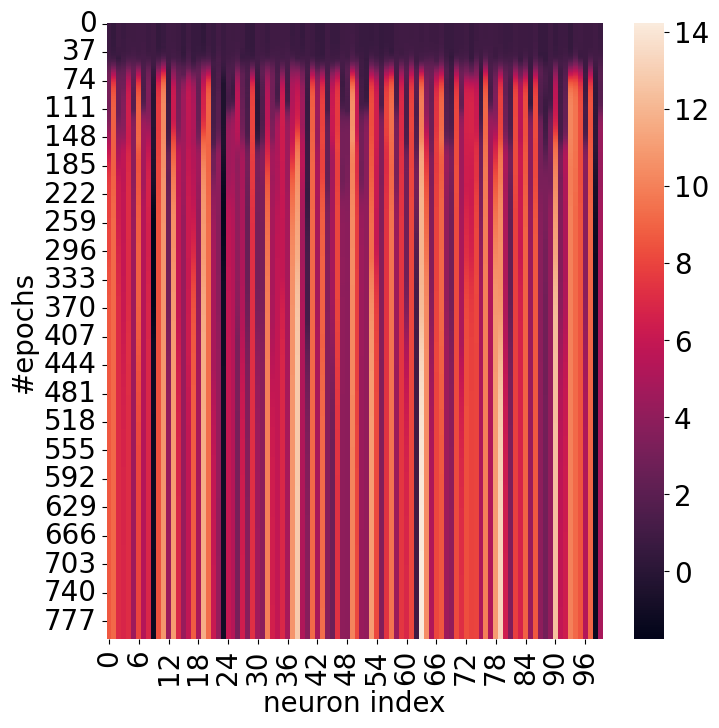

In [87]:
# visualize the top 1 gating output
import seaborn as sns
gating_outputs_tensor = torch.stack(gating_outputs)
ax = sns.heatmap(gating_outputs_tensor[:,0:100])
ax.set_xlabel('neuron index')
ax.set_ylabel('#epochs')

## Here we visualize $\text{argmax}(G(x))$

Text(56.722222222222214, 0.5, '#epochs')

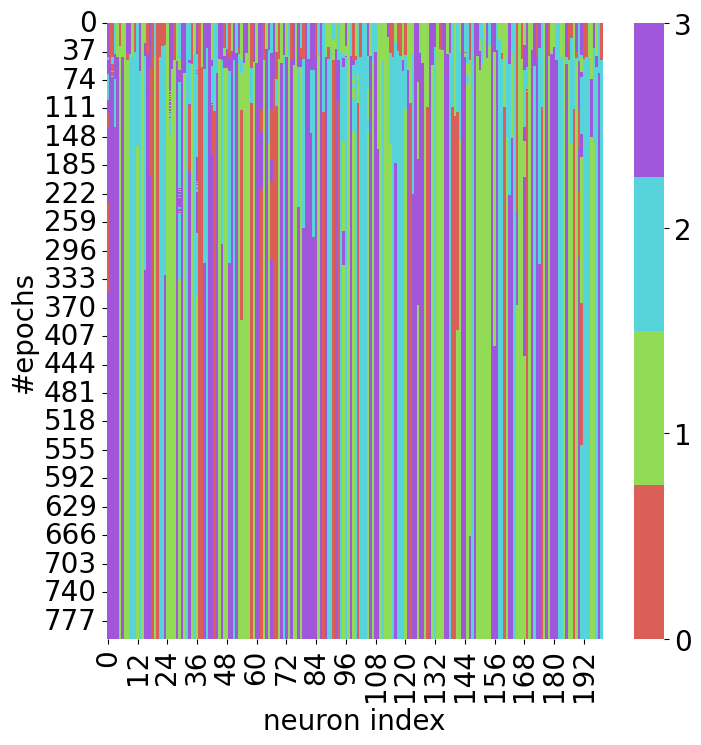

In [89]:
# now let us visualize each data point's expert assignment in each training epoch
import seaborn as sns
index__ = torch.stack(index_ )
start_i = 400
ax = sns.heatmap(index__[:,start_i:start_i+200],cmap=sns.color_palette("hls",n_colors=4))
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0,1,2,3])
colorbar.set_ticklabels([0,1,2,3])
ax.set_xlabel('neuron index')
ax.set_ylabel('#epochs')

In [72]:
expert_1 = (select[:,0] == 1).cpu()
expert_2 = (select[:,1] == 1).cpu()
expert_3 = (select[:,2] == 1).cpu()
expert_4 = (select[:,3] == 1).cpu()

expert_1_idx = torch.arange(DATA_NUM).long()[expert_1]
expert_2_idx = torch.arange(DATA_NUM).long()[expert_2]
expert_3_idx = torch.arange(DATA_NUM).long()[expert_3]
expert_4_idx = torch.arange(DATA_NUM).long()[expert_4]

In [73]:
pred, _, _,_,_ = nonlinear_mixture(training_data)

resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(visual_data[:,0]), np.max(visual_data[:,0])
X2d_ymin, X2d_ymax = np.min(visual_data[:,1]), np.max(visual_data[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(visual_data, torch.max(pred.data, 1).indices.cpu().numpy()) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

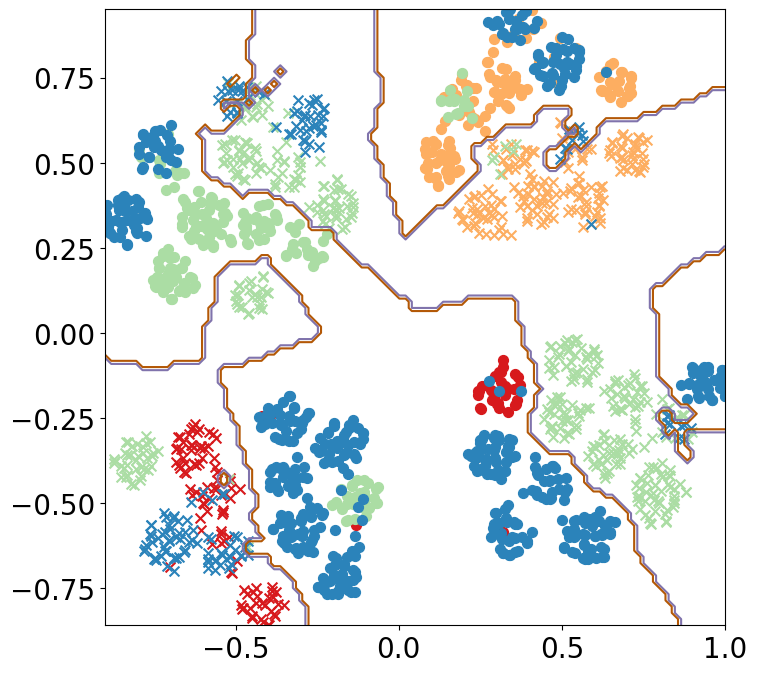

In [74]:
plt.scatter(visual_data[np.array(expert_1_idx)[training_labels.cpu()[expert_1] == 0],0],visual_data[np.array(expert_1_idx)[training_labels.cpu()[expert_1] == 0],1], s=50, marker='x',color='#d7191c')
plt.scatter(visual_data[np.array(expert_1_idx)[training_labels.cpu()[expert_1] == 1],0],visual_data[np.array(expert_1_idx)[training_labels.cpu()[expert_1] == 1],1], s=50, marker='o',color='#d7191c')

plt.scatter(visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 0],0],visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 0],1], s=50, marker='x',color='#fdae61')
plt.scatter(visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 1],0],visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 1],1], s=50, marker='o',color='#fdae61')

plt.scatter(visual_data[np.array(expert_3_idx)[training_labels.cpu()[expert_3] == 0],0],visual_data[np.array(expert_3_idx)[training_labels.cpu()[expert_3] == 0],1], s=50, marker='x',color='#abdda4')
plt.scatter(visual_data[np.array(expert_3_idx)[training_labels.cpu()[expert_3] == 1],0],visual_data[np.array(expert_3_idx)[training_labels.cpu()[expert_3] == 1],1], s=50, marker='o',color='#abdda4')

plt.scatter(visual_data[np.array(expert_4_idx)[training_labels.cpu()[expert_4] == 0],0],visual_data[np.array(expert_4_idx)[training_labels.cpu()[expert_4] == 0],1], s=50, marker='x',color='#2b83ba')
plt.scatter(visual_data[np.array(expert_4_idx)[training_labels.cpu()[expert_4] == 1],0],visual_data[np.array(expert_4_idx)[training_labels.cpu()[expert_4] == 1],1], s=50, marker='o',color='#2b83ba')

plt.contour(xx, yy, voronoiBackground, levels=1, colors=['#8073ac','#b35806'])

plt.savefig('intermediate.pdf')

In [61]:
num_epochs = 801
noise = torch.rand(DATA_NUM,EXPERT_NUM).cuda()
nonlinear_mixture = MoE(200, 10, PATCH_NUM, EXPERT_NUM, strategy='top1', nonlinear=True, noise=None, noise_type='gumbel').cuda() #input_dim, out_channel (m), cluter_num, patch_num

criterion = torch.nn.CrossEntropyLoss()
optimizer = NormalizedGD(nonlinear_mixture.models.parameters(), lr=0.001)
optimizer2 = torch.optim.SGD(nonlinear_mixture.router.parameters(), lr=0.1) #top1 lr 0.1


_, _, _, _, select, _, router_grads, gating_outputs, index_ = train(nonlinear_mixture, criterion, training_data, training_labels, 
                                                           [optimizer,optimizer2], num_epochs, plot=False, load_balancing=True)
print(select.squeeze(-1).sum(dim=0))

test(nonlinear_mixture, criterion, training_data, training_labels)
test(nonlinear_mixture, criterion, test_data, test_labels)

print(select[train_cluster_idx[0]].squeeze(-1).sum(dim=0).to(torch.long))
print(select[train_cluster_idx[1]].squeeze(-1).sum(dim=0).to(torch.long))
print(select[train_cluster_idx[2]].squeeze(-1).sum(dim=0).to(torch.long))
print(select[train_cluster_idx[3]].squeeze(-1).sum(dim=0).to(torch.long))

Epoch 1 --- loss: 0.693
Epoch 101 --- loss: 0.577
Epoch 201 --- loss: 0.445
Epoch 301 --- loss: 0.356
Epoch 401 --- loss: 0.344
Epoch 501 --- loss: 0.338
Epoch 601 --- loss: 0.336
Epoch 701 --- loss: 0.336
Epoch 801 --- loss: 0.335
Finished Training
tensor([376., 296., 347., 581.], device='cuda:0')
Accuracy of the network on the 1600 test images: 97.8750 %
Accuracy of the network on the 1600 test images: 95.6250 %
tensor([ 18,   9, 343,  47], device='cuda:0')
tensor([105, 142,   1, 166], device='cuda:0')
tensor([ 45, 120,   2, 227], device='cuda:0')
tensor([208,  25,   1, 141], device='cuda:0')


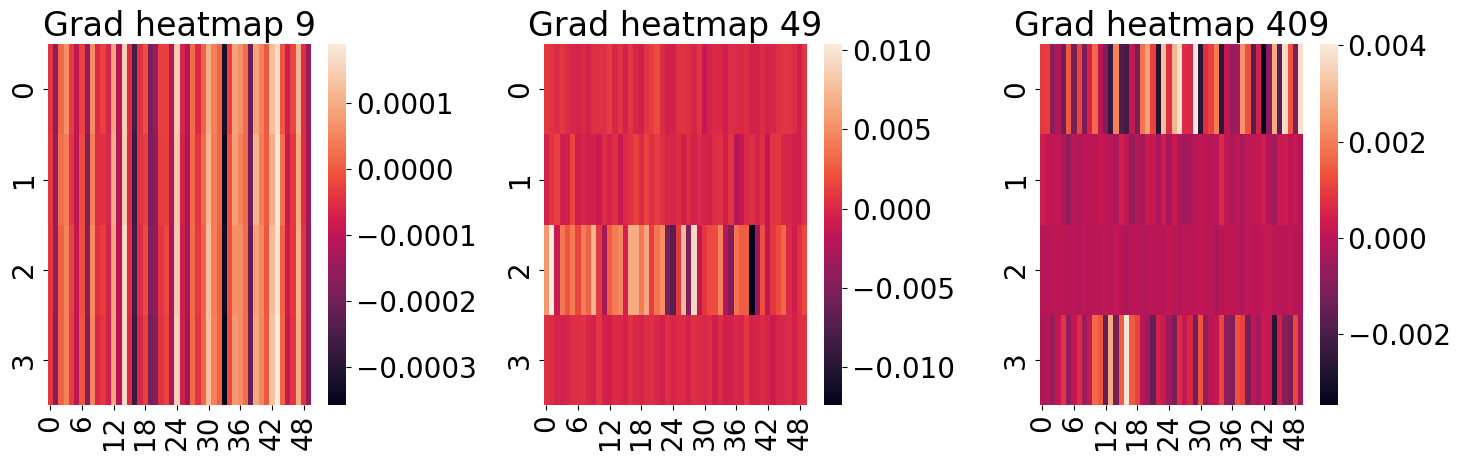

In [64]:
# Set up a 1x3 grid for subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first heatmap
sns.heatmap(torch.squeeze(router_grads[9]).cpu(), fmt="d", cbar=True, ax=axes[0])
axes[0].set_title('Grad heatmap 9')

# Plot the second heatmap
sns.heatmap(torch.squeeze(router_grads[49]).cpu(),fmt="d", cbar=True, ax=axes[1])
axes[1].set_title('Grad heatmap 49')

# Plot the third heatmap
sns.heatmap(torch.squeeze(router_grads[409]).cpu(),  fmt="d", cbar=True, ax=axes[2])
axes[2].set_title('Grad heatmap 409')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [102]:
expert_1 = (select[:,0] == 1).cpu()
expert_2 = (select[:,1] == 1).cpu()
expert_3 = (select[:,2] == 1).cpu()
expert_4 = (select[:,3] == 1).cpu()

expert_1_idx = torch.arange(DATA_NUM).long()[expert_1]
expert_2_idx = torch.arange(DATA_NUM).long()[expert_2]
expert_3_idx = torch.arange(DATA_NUM).long()[expert_3]
expert_4_idx = torch.arange(DATA_NUM).long()[expert_4]

In [103]:
pred, _, _ = nonlinear_mixture(training_data)

resolution = 100 # 100x100 background pixels
X2d_xmin, X2d_xmax = np.min(visual_data[:,0]), np.max(visual_data[:,0])
X2d_ymin, X2d_ymax = np.min(visual_data[:,1]), np.max(visual_data[:,1])
xx, yy = np.meshgrid(np.linspace(X2d_xmin, X2d_xmax, resolution), np.linspace(X2d_ymin, X2d_ymax, resolution))

# approximate Voronoi tesselation on resolution x resolution grid using 1-NN
background_model = KNeighborsClassifier(n_neighbors=1).fit(visual_data, torch.max(pred.data, 1).indices.cpu().numpy()) 
voronoiBackground = background_model.predict(np.c_[xx.ravel(), yy.ravel()])
voronoiBackground = voronoiBackground.reshape((resolution, resolution))

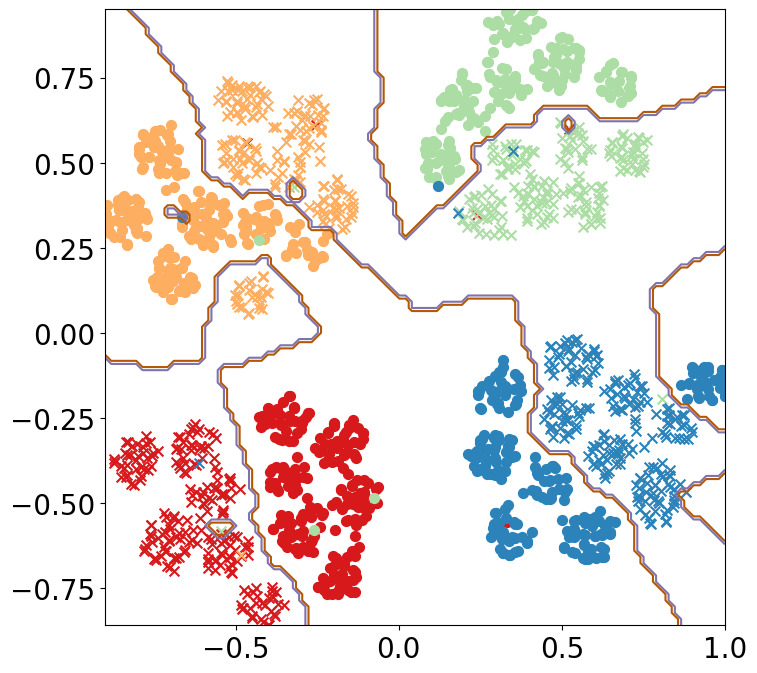

In [104]:
plt.scatter(visual_data[np.array(expert_1_idx)[training_labels.cpu()[expert_1] == 0],0],visual_data[np.array(expert_1_idx)[training_labels.cpu()[expert_1] == 0],1], s=50, marker='x',color='#d7191c')
plt.scatter(visual_data[np.array(expert_1_idx)[training_labels.cpu()[expert_1] == 1],0],visual_data[np.array(expert_1_idx)[training_labels.cpu()[expert_1] == 1],1], s=50, marker='o',color='#d7191c')

plt.scatter(visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 0],0],visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 0],1], s=50, marker='x',color='#fdae61')
plt.scatter(visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 1],0],visual_data[np.array(expert_2_idx)[training_labels.cpu()[expert_2] == 1],1], s=50, marker='o',color='#fdae61')

plt.scatter(visual_data[np.array(expert_3_idx)[training_labels.cpu()[expert_3] == 0],0],visual_data[np.array(expert_3_idx)[training_labels.cpu()[expert_3] == 0],1], s=50, marker='x',color='#abdda4')
plt.scatter(visual_data[np.array(expert_3_idx)[training_labels.cpu()[expert_3] == 1],0],visual_data[np.array(expert_3_idx)[training_labels.cpu()[expert_3] == 1],1], s=50, marker='o',color='#abdda4')

plt.scatter(visual_data[np.array(expert_4_idx)[training_labels.cpu()[expert_4] == 0],0],visual_data[np.array(expert_4_idx)[training_labels.cpu()[expert_4] == 0],1], s=50, marker='x',color='#2b83ba')
plt.scatter(visual_data[np.array(expert_4_idx)[training_labels.cpu()[expert_4] == 1],0],visual_data[np.array(expert_4_idx)[training_labels.cpu()[expert_4] == 1],1], s=50, marker='o',color='#2b83ba')

plt.contour(xx, yy, voronoiBackground, levels=1, colors=['#8073ac','#b35806'])
# plt.savefig('final.pdf')